In [1]:
import matplotlib.pyplot as plt
import numpy as np


Create Your Own Lattice Boltzmann Simulation (With Python)
Philip Mocz (2020) Princeton Univeristy, @PMocz
https://github.com/pmocz/latticeboltzmann-python/blob/main/latticeboltzmann.py

Simulate flow past cylinder
for an isothermal fluid

#### I modified the code to simulate poiseuille flow and compare with analytical solution.

In [2]:
# Simulation parameters
Nx = 400 # resolution x-dir
Ny = 100 # resolution y-dir
rho0 = 0.6 # average density
tau = 0.6 # collision timescale
Nt = 400 # number of time steps

In [3]:
# Lattice speeds / weights
Nl = 9
idxs = np.arange(Nl)
cxs = np.array([0,0,1,1,1,0,-1,-1,-1])
cys = np.array([0,1,1,0,-1,-1,-1,0,1])
weights = np.array([4/9,1/9,1/36,1/9,1/36,1/9,1/36,1/9,1/36]) # sums to 1

![a 2 dimensional lattice with 9 possible velocities at each lattice site (D2Q9)](https://miro.medium.com/v2/resize:fit:640/format:webp/1*p68lcBLpmVQqT9vreqMTog.png)

In [4]:
# Initial conditions
F = np.ones((Ny,Nx,Nl))
np.random.seed(1)
F += 0.01*np.random.rand(Ny,Nx,Nl)
X, Y = np.meshgrid(range(Nx), range(Ny))
F[:,:,3] += 2 * (1+0.2*np.cos(2*np.pi*X/Nx*4))  # increase ux as a sin function

#np.set_printoptions(threshold=np.inf)
#print(F)
rho = np.sum(F,2)
for i in idxs:
    F[:,:,i] *= rho0 / rho


In [5]:
# Cylinder boundary

cylinder =  (X - Nx/4)**2 + (Y - Ny/2)**2 < (Ny/4)**2
#print(X)
#print(Y)
#print(cylinder.astype(int))


In [6]:
rho = np.sum(F,2)
ux  = np.sum(F*cxs,2) / rho
uy  = np.sum(F*cys,2) / rho
#print(ux)
# print('Orignial tensor A')
# print(np.ones((4,5,6)))
# print('A*x')                         # NOT matrix multiplication
# print(np.ones((4,5,6))*np.arange(6))
# print('A@x')                         # matrix multiplication
# print(np.ones((4,5,6))@np.arange(6))

In [7]:
# Prep figure
fig = plt.figure(figsize=(4,2), dpi=80)

<Figure size 320x160 with 0 Axes>

In [8]:
# for i, cx, cy in zip(idxs, cxs, cys):
#     print(i, cx, cy)

The zip() function is a built-in Python function that is used to combine multiple iterables (like lists or tuples) element-wise. The resulting output is an iterator that produces tuples. The i-th tuple contains the i-th element from each of the input iterables.

In [9]:
# A = np.ones((3,5,7))*np.arange(7)*np.arange(5)[:, np.newaxis]*np.array([1,2,3])[:, np.newaxis, np.newaxis]
# print(A)
# print(np.roll(A,1,axis=2))
# The np.roll(A, 1, axis=2) function shifts each element of the array A cyclically 
# by one position along the third axis, 
# with the last element wrapping around to the first position

The particles will do two things. Stream and collide. This behavior can be captured by the BGK approximation:

$$ 
F_i(\boldsymbol{x}_i + \boldsymbol{v}_i \Delta t, t+\Delta t)-F_i(\boldsymbol{x}_i, t)
= - \frac{F_i(\boldsymbol{x}_i, t) - F_i^{eq}(\boldsymbol{x}_i, t)}{\tau}
$$

Moments of the discrete distribution function can be taken to recover fluid variables at each lattice site. For example, the density:

$$
\rho = \sum F_i
$$

and momentum:
$$
\rho \boldsymbol{u} = \sum F_i \boldsymbol{v}_i
$$
where the sum is over all lattice directions.
It can be shown that this description approximates the Navier-Stokes fluid equations:
https://www.ndsu.edu/fileadmin/physics.ndsu.edu/Wagner/LBbook.pdf

#### Streaming
The first step in the Lattice Boltzmann method is to stream the particles. This step is incredibly simple. Conceptually, here is what happens. At each lattice site, for each direction $i$, the value $Fᵢ$ is shifted over to the neighboring lattice site along the connection.

Typically in the Lattice Boltzmann method uses units of $Δt=Δx=1$ and we will use this convention throughout. The streaming velocities are hence: (0,0), (0,1), (0,-1), (1,0), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1).

#### Collisions
Next we need to define the equilibrium state as a result of collisions. This depends on the fluid model’s equation of state. For this example, we will assume an isothermal (constant temperature) fluid, which has a constant sound speed. We define units using common conventions such that the lattice speed is $c=1$ (which corresponds $soundspeed²=1/3$). The equilibrium state is given by:

$$
F_i^{eq} = w_i \rho (1+3(\boldsymbol{v}_i \cdot \boldsymbol{u}) + \frac{9}{2}(\boldsymbol{v}_i \cdot \boldsymbol{u})^2) + \frac{3}{2}(\boldsymbol{u} \cdot \boldsymbol{u})
$$
which corresponds to the isothermal Navier-Stokes equations with a dynamic viscosity:
$$ \mu = \rho(\tau-\frac{1}{2}) \Delta t $$

#### Boundary
Boundary conditions in Lattice Boltzmann are implemented on the microscopic level. In our simulation, we wish to add a solid cylinder. Lattice sites part of this cylinder may be flagged. Here particles will behave differently. In our example, we will consider reflective boundary conditions. Instead of collisions that lead to equilibrium, particles will simply bounce back. This is easily accomplished by swapping lattice directions.

### Lattice Boltzmann Method
That’s it conceptually. Let’s put it all together! The following code sets up the lattice and initial condition for $F_i$, and alternates streaming and collision(+boundary) operators to evolve the system. It is remarkable that this restricted microscopic representation is able to capture macroscopic fluid behavior.

0


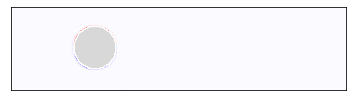

100


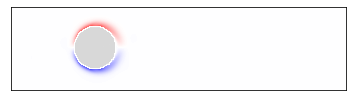

200


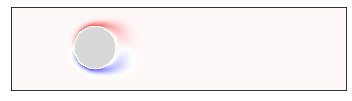

300


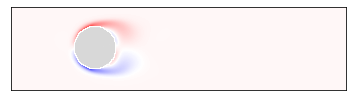

399


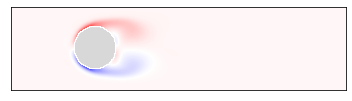

<Figure size 432x288 with 0 Axes>

In [10]:
import io
import imageio.v2 as imageio
# Initialize a list to store the frames
frames = []

for it in range(Nt):
    
    # Drift
    for i, cx, cy in zip(idxs, cxs, cys):
        # Streaming
        F[:,:,i] = np.roll(F[:,:,i], cx, axis=1)
        F[:,:,i] = np.roll(F[:,:,i], cy, axis=0)

        # Set reflective boundaries
        bndryF = F[cylinder,:]
        bndryF = bndryF[:,[0,5,6,7,8,1,2,3,4]]

        # Calculate fluid variables
        rho = np.sum(F,2)
        ux  = np.sum(F*cxs,2) / rho
        uy  = np.sum(F*cys,2) / rho

        # Apply Collision
        Feq = np.zeros(F.shape)
        for i, cx, cy, w in zip(idxs, cxs, cys, weights):
            Feq[:,:,i] = rho * w * ( 1 + 3*(cx*ux+cy*uy)  
                                    + 9*(cx*ux+cy*uy)**2/2 - 3*(ux**2+uy**2)/2 )

        F += -(1.0/tau) * (F - Feq)

        # Apply boundary 
        F[cylinder,:] = bndryF


        # plot in real time - color 1/2 particles blue, other half red
    if ((it % 100) == 0) or (it == Nt-1):
        print(it)
        plt.cla()
        ux[cylinder] = 0
        uy[cylinder] = 0
        vorticity = (np.roll(ux, -1, axis=0) - np.roll(ux, 1, axis=0)) - (np.roll(uy, -1, axis=1) - np.roll(uy, 1, axis=1))
        vorticity[cylinder] = np.nan
        vorticity = np.ma.array(vorticity, mask=cylinder)
        plt.imshow(vorticity, cmap='bwr')
        plt.imshow(~cylinder, cmap='gray', alpha=0.3)
        plt.clim(-.1, .1)
        ax = plt.gca()
        ax.invert_yaxis()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
        plt.pause(0.001)
        
        plt.savefig(f'frame_{it}.png', dpi=240)
        frames.append(imageio.imread(f'frame_{it}.png'))

# Save figure

plt.show()

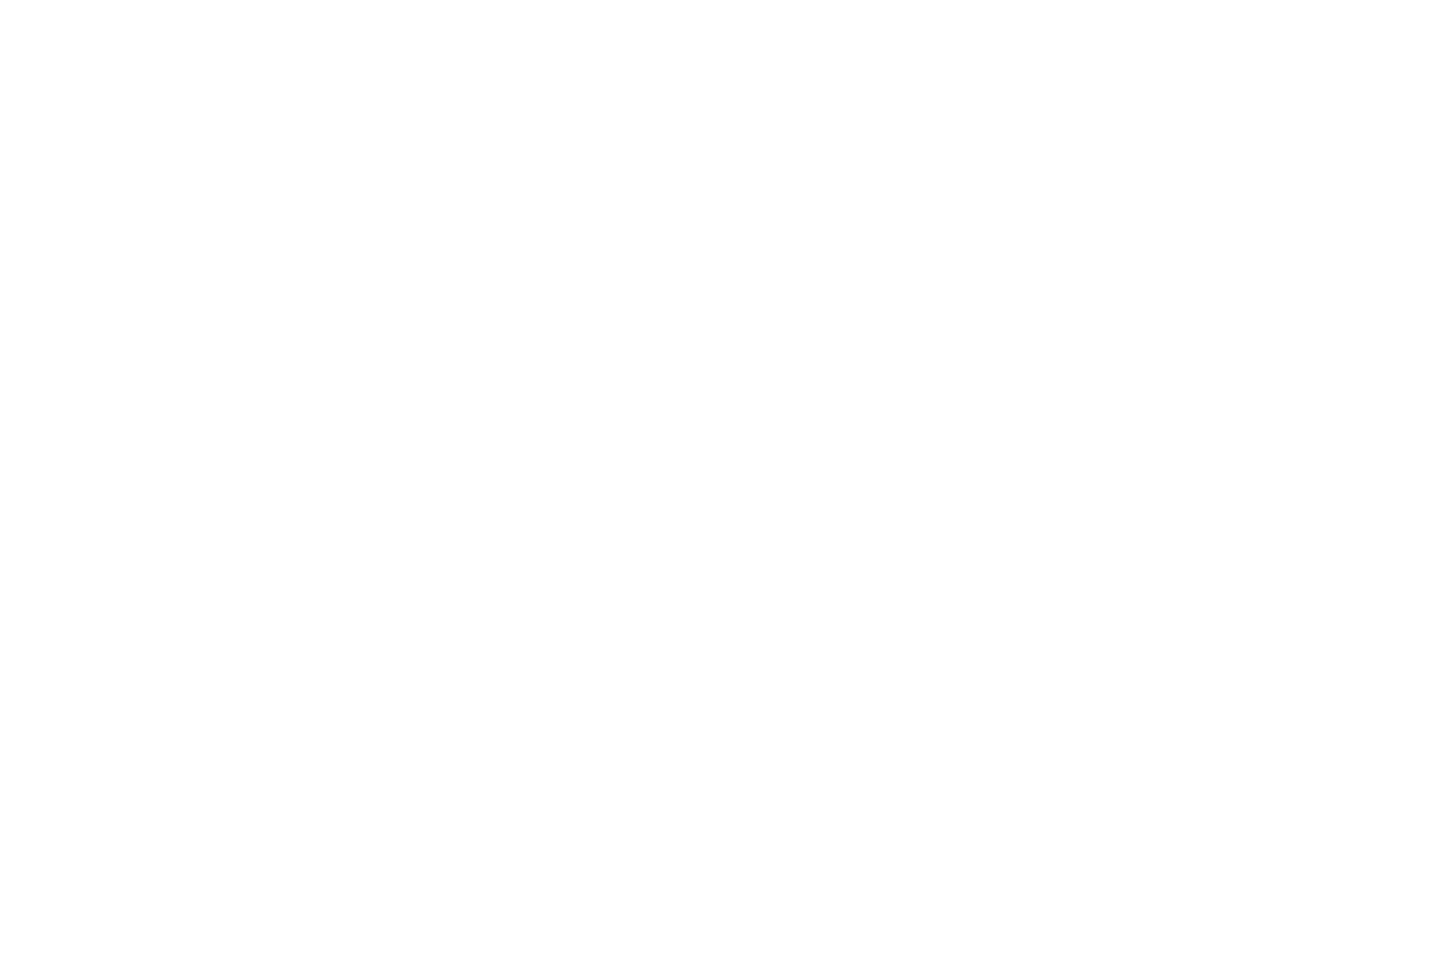

In [11]:
from IPython.display import Image
# Create the GIF
gif_path = 'latticeboltzmann.gif'
imageio.mimsave(gif_path, frames, duration=0.1)

# Display the GIF in the notebook
Image(open(gif_path, 'rb').read())

Flow Past Cylinder
The initial conditions above place a static cylinder into a periodic box with rightward moving fluid. As the flow progresses, turbulence develops in the wake behind the cylinder. This is known as the Kármán vortex street.

Running the code allows you to visualize the vorticity $ω=∇×v$ of the flow past the cylinder in real time.

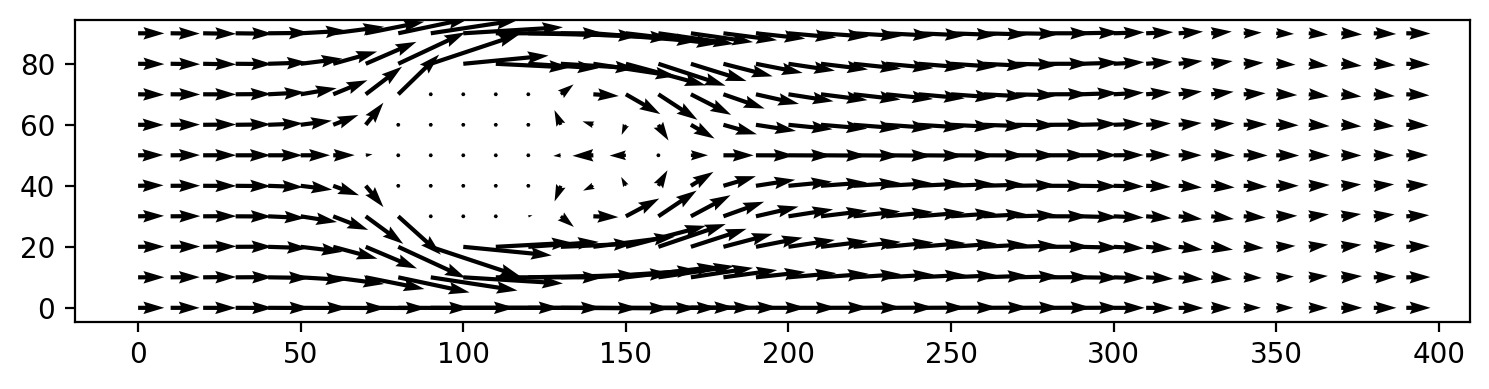

In [12]:
fig = plt.figure(figsize=(9,2), dpi=200)

plt.quiver(X[::10, ::10], Y[::10, ::10], ux[::10, ::10], uy[::10, ::10]);